In [15]:
import os
from getpass import getpass
import dotenv
from dotenv import load_dotenv

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Text-mining-for-taxonomy"
load_dotenv()

True

In [16]:
import logging
import operator
from typing_extensions import Annotated, List, Optional, TypedDict

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("tnt-llm")

class Doc(TypedDict):
    id: str
    content: str
    summary: Optional[str]
    explanation: Optional[str]
    category: Optional[str]

class TaxonomyGenerationState(TypedDict):
    # The raw docs; we inject summaries within them in the first step
    documents: List[Doc]
    # Indices to be concise
    minibatches: List[List[int]]
    # Candidate Taxonomes (full trajectory)
    clusters: Annotated[List[List[dict]], operator.add]

# Summarize docs

Chat logs can get quite long. Taxonomy generation step needs to see large, diverse minibatches to be able to adequately capture the distribution of categories. To ensure they can all fit efficiently into the context window, First summarize each chat log. Downstream steps will use these summaries instead of the raw doc content.

In [17]:
import re
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough

summary_prompt = hub.pull("wfh/tnt-llm-summary-generation").partial(
    summary_prompt=20, explanation_length=30
)

def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"

    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)

    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""

    return {"summary": summary, "explanation": explanation}

summary_llm_chain = (
    summary_prompt
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
    # Customise the tracking name for easier organization
).with_config(run_name="GenerateSummary")
summary_chain = summary_llm_chain | parse_summary

# Now combine as a "map" operation in a map-reduce chain 
# Input: state
# Output: state U summaries
# Processes docs in parallel
def get_content(state: TaxonomyGenerationState):
    docs = state['documents']
    return [{"content": doc['content'], "summary_length": 20} for doc in docs]  # Adjust the summary_length value as needed


map_step = RunnablePassthrough.assign(
    summaries=get_content
    # This effectively creates a "map" operation
    # Note you can make this more robust by handling individual errors
    | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)

def reduce_summaries(combined: dict) -> TaxonomyGenerationState:
    summaries = combined['summaries']
    documents = combined['documents']
    return {
        "documents": [
            {
                "id": doc['id'],
                "content": doc['content'],
                "summary": summ_info['summary'],
                "explanation": summ_info['explanation'],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }
map_reduce_chain = map_step | reduce_summaries

# Split into Minibatches

Each minibatch contains a random sample of docs. This lets the flow identify inadequacies in the current taxonomy using new data.

In [18]:
import random

def get_minibatches(state: TaxonomyGenerationState, config: RunnableConfig):
    batch_size = config['configurable'].get("batch_size", 200)
    original = state['documents']
    indices = list(range(len(original)))
    random.shuffle(indices)
    if len(indices) < batch_size:
        return {"minibatches": [indices]}
    
    num_full_batches = len(indices) // batch_size

    batches = [
        indices[i * batch_size: (i+1) * batch_size] for i in range(num_full_batches)
    ]
    leftovers = len(indices) % batch_size
    if leftovers:
        last_batch = indices[num_full_batches * batch_size :]
        elements_to_add = batch_size - leftovers
        last_batch += random.sample(indices, elements_to_add)
        batches.append(last_batch)

    return {"minibatches": batches}


# Taxonomy Generation Utilities

In [19]:
from typing import Dict
from langchain_core.runnables import Runnable

def parse_taxa(output_text: str) -> Dict:
    """Extract the taxonomy from the generated output."""
    cluster_matches = re.findall(
        r"\s*<id>(.*?)</id>\s*<name>(.*?)</name>\s*<description>(.*?)</description>\s*",
        output_text,
        re.DOTALL,
    )
    clusters = [
        {'id': id.strip(), "name": name.strip(), "description": description.strip()}
        for id, name, description in cluster_matches
    ]
    # We don't parse the explanation since it isn't used downstream
    return {'clusters': clusters}

def format_docs(docs: List[Doc]) -> str:
    xml_table = "<conversation>\n"
    for doc in docs:
        xml_table += f'<conv_summ id={doc["id"]}>{doc["summary"]}</conv_summ>\n'
    xml_table +="</conversation>"
    return xml_table

def format_taxonomy(clusters):
    xml = "<cluster_table>\n"
    for label in clusters:
        xml += "  <cluster>\n"
        xml += f'    <id>{label["id"]}</id>\n'
        xml += f'    <name>{label["name"]}</name>\n'
        xml += f'    <description>{label["description"]}</description>\n'
        xml += "  </cluster>\n"
    xml += "</cluster_table>"
    return xml

def invoke_taxonomy_chain(
        chain: Runnable,
        state: TaxonomyGenerationState,
        config: RunnableConfig,
        mb_indices: List[int],
) -> TaxonomyGenerationState:
    configurable = config['configurable']
    docs = state['documents']
    minibatch = [docs[idx] for idx in mb_indices]
    data_table_xml = format_docs(minibatch)

    previous_taxonomy = state['clusters'][-1] if state['clusters'] else []
    cluster_table_xml = format_taxonomy(previous_taxonomy)

    updated_taxonomy = chain.invoke(
        {"data_xml": data_table_xml,
         "use_case": configurable['use_case'],
         "cluster_table_xml": cluster_table_xml,
         "suggestion_length": configurable.get("suggestion_length", 30),
         "cluster_name_length": configurable.get("cluster_name_length", 10),
         "cluster_description_length": configurable.get("cluster_description_length", 30),
         "explanation_length": configurable.get("explanation_length", 20),
         "max_num_clusters": configurable.get("max_num_clusters", 25),
         }
    )

    return {
        "clusters": [updated_taxonomy['clusters']],
    }



# Generate initial taxonomy

In [20]:
# We will share an LLM for each step of the generate -> update -> review cycle
taxonomy_generation_llm = ChatOpenAI(model="gpt-4o")

# Initial generation
taxonomy_generation_prompt = hub.pull("wfh/tnt-llm-taxonomy-generation").partial(
    use_case='Generate the taxonomy that can be used to label the user intent in the conversation.',
)

taxa_gen_llm_chain = (
    taxonomy_generation_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name='GenerateTaxonomy')

generate_taxonomy_chain = taxa_gen_llm_chain | parse_taxa

def generate_taxonomy(
        state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    return invoke_taxonomy_chain(
        generate_taxonomy_chain, state, config, state['minibatches'][0]
    )

# Update Taxonomy

In [21]:
taxonomy_update_prompt = hub.pull("wfh/tnt-llm-taxonomy-update")

taxa_update_llm_chain = (
    taxonomy_update_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name='UpdateTaxonomy')

update_taxonomy_chain = taxa_update_llm_chain | parse_taxa

def update_taxonomy(
        state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    which_mb = len(state['clusters']) % len(state['minibatches'])
    return invoke_taxonomy_chain(
        update_taxonomy_chain, state, config, state['minibatches'][which_mb]
)

# Review Taxonomy

In [22]:
taxonomy_review_prompt = hub.pull("wfh/tnt-llm-taxonomy-review")
taxa_review_llm_chain = (
    taxonomy_review_prompt | taxonomy_generation_llm | StrOutputParser()
).with_config(run_name='ReviewTaxonomy')

review_taxonomy_chain = taxa_review_llm_chain | parse_taxa

def review_taxonomy(
        state: TaxonomyGenerationState, config: RunnableConfig
) -> TaxonomyGenerationState:
    batch_size = config['configurable'].get("batch_size", 200)
    original = state['documents']
    indices = list(range(len(original)))
    random.shuffle(indices)
    return invoke_taxonomy_chain(
        review_taxonomy_chain, state, config, indices[:batch_size]
    )

# Define the Graph

In [23]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(TaxonomyGenerationState)
graph.add_node("summarize", map_reduce_chain)
graph.add_node("get_minibatches", get_minibatches)
graph.add_node("generate_taxonomy", generate_taxonomy)
graph.add_node("update_taxonomy", update_taxonomy)
graph.add_node("review_taxonomy", review_taxonomy)

graph.add_edge('summarize', 'get_minibatches')
graph.add_edge("get_minibatches", "generate_taxonomy")
graph.add_edge("generate_taxonomy", 'update_taxonomy')

def should_review(state: TaxonomyGenerationState) -> str:
    num_minibatches = len(state['minibatches'])
    num_revisions = len(state['clusters'])
    if num_revisions < num_minibatches:
        return "update_taxonomy"
    return "review_taxonomy"
graph.add_conditional_edges(
    "update_taxonomy",
    should_review,
    # Optional (but required for the diagram to be drawn correctly below)
    {"update_taxonomy": "update_taxonomy", 'review_taxonomy': "review_taxonomy"},
)
graph.add_edge('review_taxonomy', END)
graph.add_edge(START, 'summarize')

app = graph.compile()

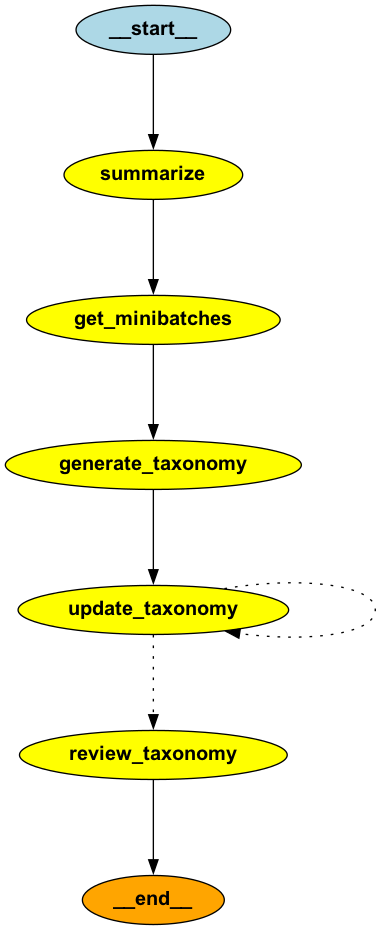

In [24]:
from IPython.display import Image

Image(app.get_graph().draw_png())

# Usage

## Download customer reviews for a products

### Kaggle Credentials

I don't want to use google drive here, so i decided to use Kaggle API to directly  download dataset from Kaggle competition page.
For this:

* First, you need to install the Kaggle API by running the following command in a code cell:   


```
!pip install kaggle
```

* Next, you need to download your Kaggle API key. To do this, go to your Kaggle account settings page, scroll down to the "API" section, and click on the "Create New API Token" button. This will download a JSON file with your Kaggle API credentials.  
link: https://www.machinelearningmindset.com/kaggle-dataset-in-google-colab/


* Upload your Kaggle API key to Jupyter Notebook by clicking on the "Files" tab on the left-hand side of the Colab interface, then click on "Upload" and select the JSON file containing your Kaggle API credentials.

* Run the following commands in a code cell to authenticate the Kaggle API:


```
import os
os.environ['KAGGLE_USERNAME'] = "your_kaggle_username"
os.environ['KAGGLE_KEY'] = "your_kaggle_api_key"

```


In [25]:
# Downloading dataset from kaggle
import os
import random
import shutil
import requests
import zipfile
from pathlib import Path

!kaggle datasets download -d nicapotato/womens-ecommerce-clothing-reviews



# Unzip journey-springfield.zip
with zipfile.ZipFile("womens-ecommerce-clothing-reviews.zip", "r") as zip_ref:
    print("Unzipping  data...") 
    zip_ref.extractall()
    print("Unzipping complete.")

Dataset URL: https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews
License(s): CC0-1.0
womens-ecommerce-clothing-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Unzipping  data...
Unzipping complete.


In [62]:
import pandas as pd

df  = pd.read_csv("./Womens Clothing E-Commerce Reviews.csv", index_col=[0])

# Function to create Doc objects
def create_docs(df):
    docs = []
    for idx, row in df.iterrows():
        doc_id = str(row['Clothing ID'])
        review_text = row['Review Text']
        doc = Doc(
            id=doc_id,
            content=f"<human id={doc_id}>\n{review_text}\n</human>",
            summary=None,        # Placeholder, replace with actual summary logic
            explanation=None,    # Placeholder, replace with actual explanation logic
            category=None        # Placeholder, replace with actual category logic
        )
        docs.append(doc)
    return docs

# Create the docs
docs = create_docs(df)
docs_random = random.sample(docs, min(len(docs), 1000))


# Invoke

In [57]:
from langchain.cache import InMemoryCache
from langchain.globals import set_llm_cache

set_llm_cache(InMemoryCache())

In [58]:
use_case = (
    "Generate the taxonomy that can be used both to label the user intent"
    " as well as to identify any required documentation (references, how-tos, etc.)"
    " that would benefit the user."
)

stream = app.stream(
    {"documents": docs_random},
    {
        "configurable": {
            "use_case": use_case,
            # Optional:
            "batch_size": 400,
            "suggestion_length": 30,
            "cluster_name_length": 10,
            "cluster_description_length": 30,
            "explanation_length": 20,
            "max_num_clusters": 25,
        },
        # We batch summarize the docs. To avoid getting errors, we will limit the
        # degree of parallelism to permit.
        "max_concurrency": 2,
    },
)

for step in stream:
    node, state = next(iter(step.items()))
    print(node, str(state)[:20] + " ...")

summarize {'documents': [{'id' ...
get_minibatches {'minibatches': [[7, ...
generate_taxonomy {'clusters': [[{'id' ...
update_taxonomy {'clusters': [[{'id' ...
review_taxonomy {'clusters': [[{'id' ...


# Final Result

In [59]:
step['review_taxonomy']

{'clusters': [[{'id': '1',
    'name': 'Product Fit and Return Issues',
    'description': 'Discussions about sizing problems and returns due to incorrect fit or dissatisfaction.'},
   {'id': '2',
    'name': 'Product Quality Feedback',
    'description': 'Feedback on product quality, including compliments and concerns.'},
   {'id': '3',
    'name': 'Product Features and Style Preferences',
    'description': 'Discussion about product features and style preferences, including recommendations.'},
   {'id': '4',
    'name': 'User Engagement Issues',
    'description': 'Situations with no user interaction or response, suggesting a lack of engagement.'},
   {'id': '5',
    'name': 'Documentation and Reference Needs',
    'description': 'Requests for user guides, how-tos, or other documentation to assist with product use.'}]]}

In [61]:
from IPython.display import Markdown

def format_taxonomy_md(clusters):
    md = "## Final Taxonomy\n\n"
    md += "| ID | Name | Description |\n"
    md += "|----|------|-------------|\n"

    # Fill the table with cluster data
    for label in clusters:
        id = label['id']
        name = label['name'].replace(
            "|", "\\|"
        ) # Escape any pipe characters within the content
        description = label['description'].replace(
            "|", "\\|"
        ) # Escape any pipe characters
        md += f"| {id} | {name} | {description} |\n"

    return md

Markdown(format_taxonomy_md(step["review_taxonomy"]['clusters'][-1]))

## Final Taxonomy

| ID | Name | Description |
|----|------|-------------|
| 1 | Product Fit and Return Issues | Discussions about sizing problems and returns due to incorrect fit or dissatisfaction. |
| 2 | Product Quality Feedback | Feedback on product quality, including compliments and concerns. |
| 3 | Product Features and Style Preferences | Discussion about product features and style preferences, including recommendations. |
| 4 | User Engagement Issues | Situations with no user interaction or response, suggesting a lack of engagement. |
| 5 | Documentation and Reference Needs | Requests for user guides, how-tos, or other documentation to assist with product use. |
